<a href="https://colab.research.google.com/github/maglili/ai_cup-mango-cnn_base/blob/main/nn_crop_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab

- 將 baseline 的下游從 svm 轉換為 nn。
- 訓練練資料的正負資料集不平衡。
- 圖片被裁切成數個小bbox

In [1]:
cd /content/drive/MyDrive/Projects/AI_CUP-Mango

/content/drive/MyDrive/Projects/AI_CUP-Mango


In [2]:
pwd

'/content/drive/MyDrive/Projects/AI_CUP-Mango'

# Preparing data

In [4]:
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pickle 
import matplotlib.pylab as plt # plot module

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible.')
  print('Working on:', torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible.')
  print('Working on CPU')

GPU is avalible.
Working on: Tesla T4


In [6]:
with open('/content/drive/MyDrive/Projects/AI_CUP-Mango/processed_data/baseline_crop/train_feature.pkl', 'rb') as f:
    train_feature = pickle.load(f)

with open('/content/drive/MyDrive/Projects/AI_CUP-Mango/processed_data/baseline_crop/dev_feature.pkl', 'rb') as f:
    dev_feature = pickle.load(f)

In [7]:
print('len of train_feature:',len(train_feature))
print('len of dev_feature:',len(dev_feature))

len of train_feature: 43370
len of dev_feature: 6280


## Spliting 5 stacks

train data set

In [8]:
c0_pos = []
c0_neg = []
c1_pos = []
c1_neg = []
c2_pos = []
c2_neg = []
c3_pos = []
c3_neg = []
c4_pos = []
c4_neg = []

In [9]:
for img, label in train_feature:
    if label[0][0] == 1:
        c0_pos.append((img, 1))
    else:
        c0_neg.append((img, 0))
    
    if label[0][1] == 1:
        c1_pos.append((img, 1))
    else:
        c1_neg.append((img, 0))

    if label[0][2] == 1:
        c2_pos.append((img, 1))
    else:
        c2_neg.append((img, 0))
        
    if label[0][3] == 1:
        c3_pos.append((img, 1))
    else:
        c3_neg.append((img, 0))
        
    if label[0][4] == 1:
        c4_pos.append((img, 1))
    else:
        c4_neg.append((img, 0))

Dev data set

In [10]:
c0_pos_dev = []
c0_neg_dev = []
c1_pos_dev = []
c1_neg_dev = []
c2_pos_dev = []
c2_neg_dev = []
c3_pos_dev = []
c3_neg_dev = []
c4_pos_dev = []
c4_neg_dev = []

In [11]:
for img, label in dev_feature:
    if label[0][0] == 1:
        c0_pos_dev.append((img, 1))
    else:
        c0_neg_dev.append((img, 0))
    
    if label[0][1] == 1:
        c1_pos_dev.append((img, 1))
    else:
        c1_neg_dev.append((img, 0))

    if label[0][2] == 1:
        c2_pos_dev.append((img, 1))
    else:
        c2_neg_dev.append((img, 0))
        
    if label[0][3] == 1:
        c3_pos_dev.append((img, 1))
    else:
        c3_neg_dev.append((img, 0))
        
    if label[0][4] == 1:
        c4_pos_dev.append((img, 1))
    else:
        c4_neg_dev.append((img, 0))

In [12]:
print('Train:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos), len(c0_neg), len(c0_pos)+len(c0_neg)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos), len(c1_neg), len(c1_pos)+len(c1_neg)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos), len(c2_neg), len(c2_pos)+len(c2_neg)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos), len(c3_neg), len(c3_pos)+len(c3_neg)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos), len(c4_neg), len(c4_pos)+len(c4_neg)))
print()

print('Dev:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos_dev), len(c0_neg_dev), len(c0_pos_dev)+len(c0_neg_dev)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos_dev), len(c1_neg_dev), len(c1_pos_dev)+len(c1_neg_dev)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos_dev), len(c2_neg_dev), len(c2_pos_dev)+len(c2_neg_dev)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos_dev), len(c3_neg_dev), len(c3_pos_dev)+len(c3_neg_dev)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos_dev), len(c4_neg_dev), len(c4_pos_dev)+len(c4_neg_dev)))

Train:
c0: pos= 2579   neg= 40791  sum= 43370
c1: pos= 502    neg= 42868  sum= 43370
c2: pos= 23587  neg= 19783  sum= 43370
c3: pos= 15045  neg= 28325  sum= 43370
c4: pos= 1657   neg= 41713  sum= 43370

Dev:
c0: pos= 391    neg= 5889   sum= 6280 
c1: pos= 90     neg= 6190   sum= 6280 
c2: pos= 3504   neg= 2776   sum= 6280 
c3: pos= 1997   neg= 4283   sum= 6280 
c4: pos= 298    neg= 5982   sum= 6280 


## Combining pos and net data

In [13]:
def data_list(pos_list, neg_list):
    """
    把正負資料合併並打散後，輸出資料
    """
    pos = pos_list
    neg = neg_list
    output = pos + neg        
    output = shuffle(output, random_state=0)
    return output

In [14]:
c0 = data_list(c0_pos, c0_neg)
c1 = data_list(c1_pos, c1_neg)
c2 = data_list(c2_pos, c2_neg)
c3 = data_list(c3_pos, c3_neg)
c4 = data_list(c4_pos, c4_neg)

c0_dev = data_list(c0_pos_dev, c0_neg_dev)
c1_dev = data_list(c1_pos_dev, c1_neg_dev)
c2_dev = data_list(c2_pos_dev, c2_neg_dev)
c3_dev = data_list(c3_pos_dev, c3_neg_dev)
c4_dev = data_list(c4_pos_dev, c4_neg_dev)

## Check label balance

In [15]:
def check_balance(data):
    """
    檢查資料數量是否一致
    """
    pos=0
    neg=0
    for i,j in data:
        if j == 1:
            pos += 1
        else:
            neg += 1
    print('pos:',pos)
    print('neg:',neg)
    print('sum:',pos+neg)

In [16]:
print('Train:')
print()
for i in [c0, c1, c2, c3, c4]:
    check_balance(i)
    print('-'*10)

Train:

pos: 2579
neg: 40791
sum: 43370
----------
pos: 502
neg: 42868
sum: 43370
----------
pos: 23587
neg: 19783
sum: 43370
----------
pos: 15045
neg: 28325
sum: 43370
----------
pos: 1657
neg: 41713
sum: 43370
----------


In [17]:
print('Dev:')
print()
for i in [c0_dev, c1_dev, c2_dev, c3_dev, c4_dev]:
    check_balance(i)
    print('-'*10)

Dev:

pos: 391
neg: 5889
sum: 6280
----------
pos: 90
neg: 6190
sum: 6280
----------
pos: 3504
neg: 2776
sum: 6280
----------
pos: 1997
neg: 4283
sum: 6280
----------
pos: 298
neg: 5982
sum: 6280
----------


## Splitting features and labels

In [18]:
def split_x_y(data):
    """
    把資料中的 feature 跟 label 分離
    """
    X=[]
    y=[]
    for i,j in data:
        X.append(i)
        y.append(j)
    return X,y

In [19]:
c0_X, c0_y = split_x_y(c0)
c1_X, c1_y = split_x_y(c1)
c2_X, c2_y = split_x_y(c2)
c3_X, c3_y = split_x_y(c3)
c4_X, c4_y = split_x_y(c4)

In [20]:
c0_X_dev, c0_y_dev = split_x_y(c0_dev)
c1_X_dev, c1_y_dev = split_x_y(c1_dev)
c2_X_dev, c2_y_dev = split_x_y(c2_dev)
c3_X_dev, c3_y_dev = split_x_y(c3_dev)
c4_X_dev, c4_y_dev = split_x_y(c4_dev)

## Function for calc metrics

In [21]:
def calc_metrics(train=True):
    if train:
        (TP, FP, TN, FN) = useful_stuff['train_metric'][-1]
        print('[Train]Total sample: {}'.format(TP+FP+TN+FN))
    else:
        (TP, FP, TN, FN) = useful_stuff['valid_metric'][-1]
        print('[Dev]Total sample: {}'.format(TP+FP+TN+FN))

    acc = (TP + TN) / (TP + FP + TN + FN)

    recall = TP / (TP + FN) #召回率是在所有正樣本當中，能夠預測多少正樣本的比例
    specificity = TN / (TN + FP) #特異度是在所有負樣本當中，能夠預測多少負樣本的比例

    precision = TP / (TP + FP) #準確率為在所有預測為正樣本中，有多少為正樣本

    f1 = (2 * recall * precision ) / (recall + precision) #F1-score則是兩者的調和平均數
    mcc = ( TP*TN - FP*FN ) / np.sqrt( ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) )

    print('TP:',TP)
    print('FP:',FP)
    print('TN:',TN)
    print('FN:',FN)
    print()
    print('acc:', acc)
    print('recall:', recall)
    print('specificity:', specificity)
    print('precision:', precision)
    print('f1:',f1)
    print('mcc:',mcc)

# class 0

## dataset

In [22]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [23]:
train_set_c0 = Data(c0_X, c0_y)
dev_set_c0 = Data(c0_X_dev, c0_y_dev)

## model

### Prepare

In [27]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [25]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [30]:
model_c0 = Net(neuron=100, p=0.2)
model_c0.to(device);

N_train = len(train_set_c0)
N_test = len(dev_set_c0)

weights = [1.0, 15.82]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c0.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c0, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c0, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # learning rate decay

## training

In [31]:
useful_stuff = train(model=model_c0, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=40)

In [34]:
torch.save(model_c0, './model/nn-crop-imbalance/model_c0.pt')

## Learning Curve

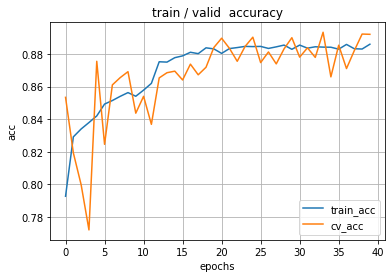

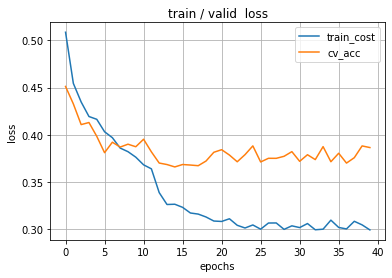

In [32]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [33]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 2211
FP: 4578
TN: 36213
FN: 368

acc: 0.885958035508416
recall: 0.8573090345094998
specificity: 0.8877693608884313
precision: 0.3256738842244808
f1: 0.47203245089666956
mcc: 0.4849300830133259
--------------------

[Dev]Total sample: 6280
TP: 300
FP: 587
TN: 5302
FN: 91

acc: 0.8920382165605095
recall: 0.7672634271099744
specificity: 0.9003226354219732
precision: 0.3382187147688839
f1: 0.4694835680751174
mcc: 0.4631689068807475


# class 1

## dataset

In [35]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [36]:
train_set_c1 = Data(c1_X, c1_y)
dev_set_c1 = Data(c1_X_dev, c1_y_dev)

## model

### Prepare

In [39]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [40]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [42]:
model_c1 = Net(neuron=100, p=0.2)
model_c1.to(device);

N_train = len(train_set_c1)
N_test = len(dev_set_c1)

weights = [1.0, 85.39]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c1.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c1, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c1, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [43]:
useful_stuff = train(model=model_c1, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=40)

In [46]:
torch.save(model_c1, './model/nn-crop-imbalance/model_c1.pt')

## Learning Curve

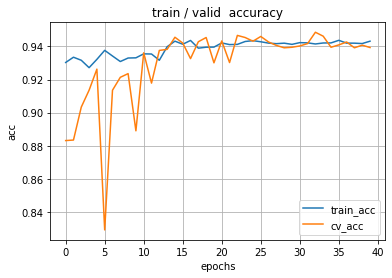

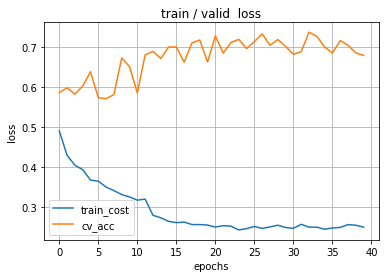

In [44]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [45]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 364
FP: 2327
TN: 40541
FN: 138

acc: 0.9431634770578741
recall: 0.7250996015936255
specificity: 0.9457170850051321
precision: 0.13526570048309178
f1: 0.22799874725963043
mcc: 0.29742696790916384
--------------------

[Dev]Total sample: 6280
TP: 43
FP: 334
TN: 5856
FN: 47

acc: 0.9393312101910828
recall: 0.4777777777777778
specificity: 0.9460420032310177
precision: 0.11405835543766578
f1: 0.18415417558886507
mcc: 0.21205120038107228


# class 2

In [47]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [48]:
train_set_c2 = Data(c2_X, c2_y)
dev_set_c2 = Data(c2_X_dev, c2_y_dev)

## model

### Prepare

In [50]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [51]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [52]:
model_c2 = Net(neuron=100, p=0.2)
model_c2.to(device);

N_train = len(train_set_c2)
N_test = len(dev_set_c2)

weights = [1.192, 1.0]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c2.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c2, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c2, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [53]:
useful_stuff = train(model=model_c2, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=40)

In [56]:
torch.save(model_c2, './model/nn-crop-imbalance/model_c2.pt')

## Learning Curve

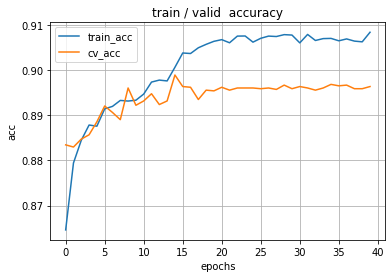

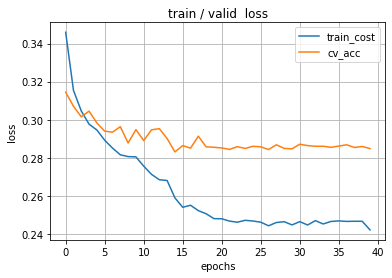

In [54]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [55]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 22456
FP: 2844
TN: 16939
FN: 1131

acc: 0.9083467834908924
recall: 0.952049857972612
specificity: 0.8562402062376788
precision: 0.8875889328063241
f1: 0.9186900402970115
mcc: 0.8166017992398801
--------------------

[Dev]Total sample: 6280
TP: 3349
FP: 496
TN: 2280
FN: 155

acc: 0.8963375796178344
recall: 0.9557648401826484
specificity: 0.8213256484149856
precision: 0.871001300390117
f1: 0.9114165192543202
mcc: 0.7920739278013277


# class 3

## dataset

In [57]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [58]:
train_set_c3 = Data(c3_X, c3_y)
dev_set_c3 = Data(c3_X_dev, c3_y_dev)

## model

### Prepare

In [61]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [62]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [63]:
model_c3 = Net(neuron=100, p=0.2)
model_c3.to(device);

N_train = len(train_set_c3)
N_test = len(dev_set_c3)

weights = [1, 1.882]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c3.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c3, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c3, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [64]:
useful_stuff = train(model=model_c3, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=40)

In [67]:
torch.save(model_c3, './model/nn-crop-imbalance/model_c3.pt')

## Learning Curve

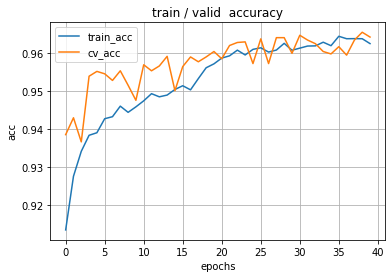

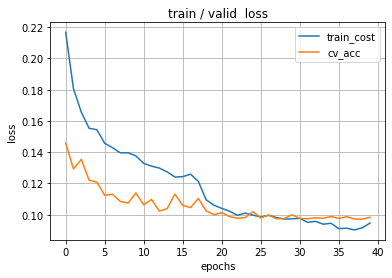

In [65]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [66]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 14553
FP: 1130
TN: 27195
FN: 492

acc: 0.9626008761816924
recall: 0.9672981056829512
specificity: 0.9601059135039718
precision: 0.927947459032073
f1: 0.9472142671179381
mcc: 0.9187503286272641
--------------------

[Dev]Total sample: 6280
TP: 1912
FP: 139
TN: 4144
FN: 85

acc: 0.9643312101910828
recall: 0.957436154231347
specificity: 0.9675461125379407
precision: 0.932228181374939
f1: 0.9446640316205532
mcc: 0.918533084374695


# class 4

## dataset

In [68]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [69]:
train_set_c4 = Data(c4_X, c4_y)
dev_set_c4 = Data(c4_X_dev, c4_y_dev)

## model

### Prepare

In [70]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [71]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [73]:
model_c4 = Net(neuron=100, p=0.2)
model_c4.to(device);

N_train = len(train_set_c4)
N_test = len(dev_set_c4)

weights = [1, 25.17]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c4.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c4, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c4, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [74]:
useful_stuff = train(model=model_c4, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=40)

In [77]:
torch.save(model_c4, './model/nn-crop-imbalance/model_c4.pt')

## Learning Curve

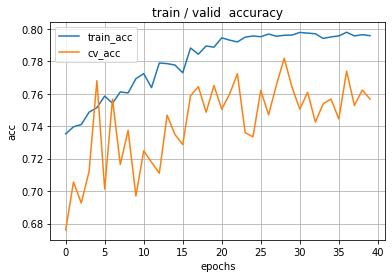

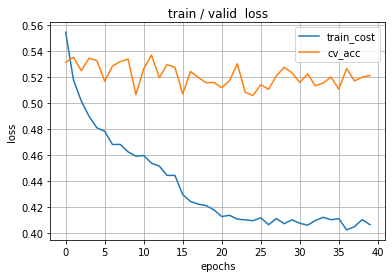

In [75]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [76]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 1322
FP: 8524
TN: 33189
FN: 335

acc: 0.7957343786027208
recall: 0.7978273989136995
specificity: 0.7956512358257618
precision: 0.13426772293317082
f1: 0.2298530818047466
mcc: 0.27157777392842364
--------------------

[Dev]Total sample: 6280
TP: 218
FP: 1448
TN: 4534
FN: 80

acc: 0.756687898089172
recall: 0.7315436241610739
specificity: 0.7579404881310599
precision: 0.13085234093637454
f1: 0.2219959266802444
mcc: 0.23571848587594973


# Saving model

In [ ]:
# torch.save(model_c0, './C2_TrainDev/model/nn-crop-imbalance/model_c0.pt')
# torch.save(model_c1, './C2_TrainDev/model/nn-crop-imbalance/model_c1.pt')
# torch.save(model_c2, './C2_TrainDev/model/nn-crop-imbalance/model_c2.pt')
# torch.save(model_c3, './C2_TrainDev/model/nn-crop-imbalance/model_c3.pt')
# torch.save(model_c4, './C2_TrainDev/model/nn-crop-imbalance/model_c4.pt')